In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'viridis'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_11/')

In [4]:
errors = compute_errors(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

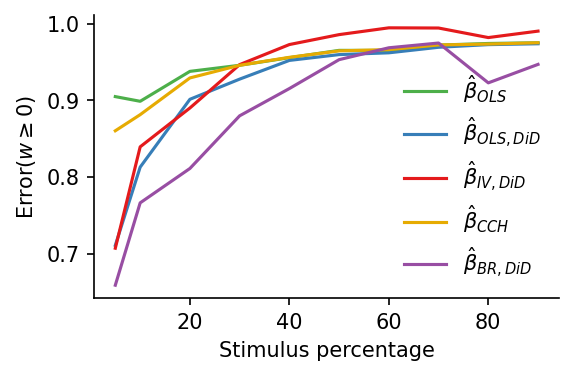

In [5]:
plot_errors(errors, 'n_stim', keys=['beta_ols', 'beta_ols_did', 'beta_iv_did', 'naive_cch', 'beta_brew_did'], 
            save='sweep_11_error_stim_percentage', xlabel='Stimulus percentage')

# Regression

In [6]:
samples = compute_all_samples(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
concsamples = pd.concat([v for v in samples.values()])
concsamples['ww'] = concsamples['weight'].round(3)

In [8]:
concsamples_sampled = concsamples.groupby('ww').sample(1)

In [ ]:
for key in ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did']:
#     plt.figure()
#     sns.scatterplot(data=concsamples, x='weight', y=key, c=concsamples['n_stim'], alpha=.7)
#     sns.despine()
    
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    sc = ax.scatter(
        concsamples['weight'],
        concsamples[key],
        c=concsamples['n_stim'],
        s=1,
        alpha=1
    )
    lab = ",".join([labels[v] for v in key.split("_")[1:]])
    ax.set_xlabel('Weight')
    ax.set_ylabel(fr'$\hat{{\beta}}_{{{lab}}}$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_ylabel('Stimulus percentage')
    sns.despine()
    savefig(f'sweep_11_scatter_{key}')

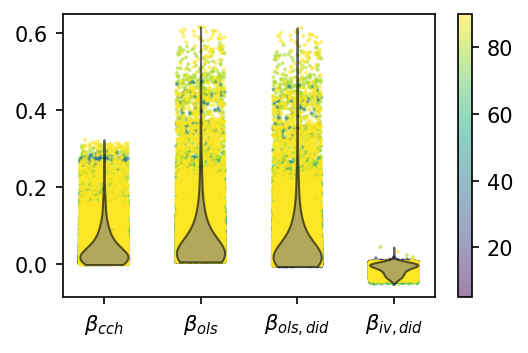

In [10]:
plot_false_positives(concsamples.query('weight==0'),
                     ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did'], 
                     scatter_color='n_stim', scatter_kws=dict(s=1, alpha=0.5))

# Classification

In [11]:
keys = ['beta_ols_did', 'beta_iv_did', 'naive_cch', 'beta_brew_did']

In [ ]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'n_stim': ser.n_stim,
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

In [ ]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="n_stim", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Stimulus percentage')
plt.ylim(0.6, 1)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_11_auroc_n_stim')

# Convergence

In [14]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/1600 [00:00<?, ?it/s]

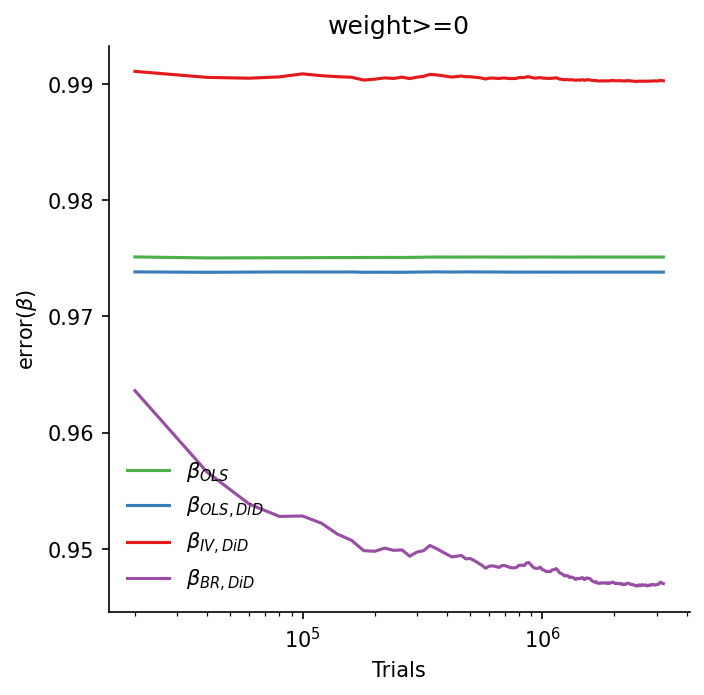

In [15]:
plot_error_convergence(error_convergence, index, keys=['beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did'])

In [16]:
error_convergence_trials = compute_error_convergence_trials(data_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

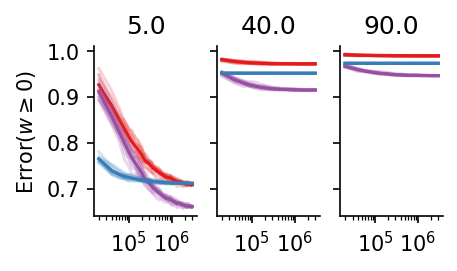

In [17]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey='row', figsize=(3,1.5), dpi=150)
for i, (sparsity, df) in enumerate(errors[list(errors.keys())[0]].query('n_stim in [5,40,90]').groupby('n_stim')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_iv_did', 'error_beta_brew_did', 'error_beta_ols_did'], 
        axs=[axs[i]], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[i].set_title(f'{sparsity:.1f}')
savefig('sweep_11_stim_percentage_convergence')

# Error differences

In [18]:
error_trials = compute_error_trials(data_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
errors = compute_error_confidence(errors, error_trials)

In [20]:
errors['weight>0'][['n_stim', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

KeyError: 'weight>0'

In [ ]:
plot_error_difference(errors, 'n_stim')

# Testing stuff

In [ ]:
from causal_optoconnectics.tools import error, error_norm

In [ ]:
def nerror(a, df, key):
    sum_e = sum((df['weight']*a - df[key])**2)
    return sum_e #/ (df['weight']).var()

In [ ]:
rng = np.arange(0.001,2,.1)
plt.plot(rng,[nerror(x, df.query('weight==0'), 'beta_ols_did') for x in rng])

In [ ]:
[min_error(df.query('weight>0'), key, fun=nerror).fun for key in ['beta_ols_did','beta_iv_did','beta_brew_did', 'naive_cch']]

In [ ]:
[df.query('weight>0')[key].var() for key in ['beta_ols_did','beta_iv_did','beta_brew_did', 'naive_cch']]

In [ ]:
plt.plot([error_norm(x, df.query('weight>0'), 'beta_ols_did') for x in np.arange(0,20,.1)])

In [ ]:
[min_error(df.query('weight>0'), key).fun for key in ['beta_ols_did','beta_iv_did','beta_brew_did', 'naive_cch']]